In [1]:
#Importing all the libraries in this cell
import sys
import os
import subprocess
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
#Calculating Accuracy
def cal_error_rate(predicted, actual):               
    wrong = 0
    for i in range(len(actual)):
        if actual[i] != predicted[i]:
            wrong = wrong + 1
    return (wrong / len(actual) * 100)

In [3]:
#Doing hmmscan and capturing scores from the result
def get_score(sequence, label):  
    def hmm_scanner():
        profile_path = f"../Datasets/HMM_profiles/{label}.hmm"
        query_path = "../Datasets/query.fasta"
        result_path = "../Datasets/result.txt"
        os.chdir("Hmmer/")
        command = ["hmmscan", "--noali", "--tblout", result_path, profile_path, query_path]
        result = subprocess.run(command, capture_output=True, text=True)
        os.chdir("..")
        
        a = open("Datasets/result.txt", "r")
        x = a.read()
        a.close()

        score_pattern = r'\b\d?\d?\d\.\d\b'
        score = re.search(score_pattern, x)
        if score:
            score = score.group()
        else:
            score = 0
        return score

    a = open("Datasets/query.fasta", "w")
    a.write(sequence)
    a.close()
    score = hmm_scanner()
    return float(score)

In [4]:
#Calculating p values
def P_cal(scores):
    assumed_score = scores[-1]
    rank = 0
    for i in range(len(scores)):
        if assumed_score >= scores[i]:
            rank = rank + 1
    return rank / len(scores)

In [5]:
#Implementing Inductive Conformal Prediction here
def ICP(test, family, cali_X, cali_y):
    cali_X.append(test)
    cali_y.append(family)
    conformity_score = []
    
    for i in range(len(cali_X)):
        greatest_score = -np.inf
        score = get_score(cali_X[i], cali_y[i])
        if score > greatest_score:
            greatest_score = score
        conformity_score.append(greatest_score)
    return conformity_score

In [6]:
#Reading all Datasets here
df = pd.read_csv("Datasets/Calibration_set.csv")
cali_X = list(df.iloc[:, 0])
cali_y = list(df.iloc[:, 1])
df = pd.read_csv("Datasets/Testing_set.csv")
shuffled_df = df.sample(frac=1, random_state=8)
test_X = list(shuffled_df.iloc[:, 0])
test_y = list(shuffled_df.iloc[:, 1])

In [7]:
families = list(set(test_y))
for_graph = []
for_graph_co = []
for_graph_cre = []
y_pred = []
predicted = []
for i in range(len(test_X)):
    p_values = []
    greatest_p_value = -np.inf
    for family in families:
        conformity_score = ICP(test_X[i], family, cali_X.copy(), cali_y.copy())
        p_values.append(P_cal(conformity_score))
    print(f"--------------------Test Sample {i+1}--------------------")
    print("families present = ",families)
    print("\n")
    for_graph.append(p_values.copy())
    print("p_values = ",p_values)
    print("\n")
    for j in range(len(p_values)):
        if p_values[j] > greatest_p_value:
            greatest_p_value = p_values[j]
            index = j
    y_pred.append(index)
    p_values.sort()
    for_graph_co.append(p_values[-1] - p_values[-2])
    for_graph_cre.append(p_values[-1])
    predicted.append(families[y_pred[i]])
    if (p_values[-1] - p_values[-2]) == 0:
        print("This sample is having similarity with 2 or more families with same p_values, so confidence is 0 and also prediction maybe wrong for this sample")
        print(f"The point prediction is '{families[y_pred[i]]}', actual family is '{test_y[i]}', confidence is {(p_values[-1] - p_values[-2])*100}%, credibility is {(p_values[-1])*100}%")
        print("\n")
    else: 
        print(f"The point prediction is '{families[y_pred[i]]}', actual family is '{test_y[i]}', confidence is {(p_values[-1] - p_values[-2])*100}%, credibility is {(p_values[-1])*100}%")
        print("\n")

print("Accuracy of the Model = ", 100 - cal_error_rate(predicted, test_y), "%")


--------------------Test Sample 1--------------------
families present =  ['PF00026', 'PF00123', 'PF00002', 'PF00110', 'PF00015', 'PF00100', 'PF00060', 'PF00022', 'PF00001', 'PF00012']


p_values =  [0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.7142857142857143, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616]


The point prediction is 'PF00110', actual family is 'PF00110', confidence is 66.66666666666667%, credibility is 71.42857142857143%


--------------------Test Sample 2--------------------
families present =  ['PF00026', 'PF00123', 'PF00002', 'PF00110', 'PF00015', 'PF00100', 'PF00060', 'PF00022', 'PF00001', 'PF00012']


p_values =  [0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.7142857142857143, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616]


The point prediction is 'PF

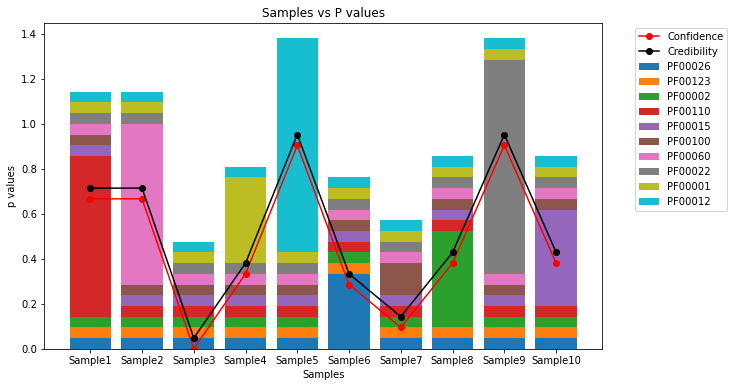

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (list of list)
line_data = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]  # Adjusted line data values
categories = ['Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6', 'Sample7', 'Sample8', 'Sample9', 'Sample10']

x = np.arange(len(for_graph))  # X-axis tick positions

# Convert list of list data to a NumPy array
stacked_data = np.array(for_graph)

plt.figure(figsize=(10,6))
# Create a stacked bar plot
plt.bar(x, stacked_data[:, 0], label=f'{families[0]}')
plt.bar(x, stacked_data[:, 1], bottom=stacked_data[:, 0], label=f'{families[1]}')
plt.bar(x, stacked_data[:, 2], bottom=stacked_data[:, 0] + stacked_data[:, 1], label=f'{families[2]}')
plt.bar(x, stacked_data[:, 3], bottom=stacked_data[:, 0] + stacked_data[:, 1] + stacked_data[:, 2], label=f'{families[3]}')
plt.bar(x, stacked_data[:, 4], bottom=stacked_data[:, 0] + stacked_data[:, 1] + stacked_data[:, 2] + stacked_data[:, 3], label=f'{families[4]}')
plt.bar(x, stacked_data[:, 5], bottom=stacked_data[:, 0] + stacked_data[:, 1] + stacked_data[:, 2] + stacked_data[:, 3] + stacked_data[:, 4], label=f'{families[5]}')
plt.bar(x, stacked_data[:, 6], bottom=stacked_data[:, 0] + stacked_data[:, 1] + stacked_data[:, 2] + stacked_data[:, 3] + stacked_data[:, 4] + stacked_data[:, 5], label=f'{families[6]}')
plt.bar(x, stacked_data[:, 7], bottom=stacked_data[:, 0] + stacked_data[:, 1] + stacked_data[:, 2] + stacked_data[:, 3] + stacked_data[:, 4] + stacked_data[:, 5] + stacked_data[:, 6], label=f'{families[7]}')
plt.bar(x, stacked_data[:, 8], bottom=stacked_data[:, 0] + stacked_data[:, 1] + stacked_data[:, 2] + stacked_data[:, 3] + stacked_data[:, 4] + stacked_data[:, 5] + stacked_data[:, 6] + stacked_data[:, 7], label=f'{families[8]}')
plt.bar(x, stacked_data[:, 9], bottom=stacked_data[:, 0] + stacked_data[:, 1] + stacked_data[:, 2] + stacked_data[:, 3] + stacked_data[:, 4] + stacked_data[:, 5] + stacked_data[:, 6] + stacked_data[:, 7] + stacked_data[:, 8], label=f'{families[9]}')

# Create a line plot
plt.plot(x, for_graph_co, marker='o', label='Confidence', color='red')
plt.plot(x, for_graph_cre, marker='o', label='Credibility', color='black')

plt.xlabel('Samples')
plt.ylabel('p values')
plt.title('Samples vs P values')
plt.xticks(x, categories)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()
